In [43]:
from fastai.vision import *

In [44]:
!ls

EXP_00			       stage_1_train.csv
EXP_10			       stage_1_train_images
EXP_20			       stage_1_train_images_png
EXP_30			       stage_1_train_with_one_image_dropped.csv
models			       test_images_224
README.md		       test_images_3chn_bg
src			       train_images_224
stage_1_sample_submission.csv  train_images_3chn_bg
stage_1_test_images	       train_labels_as_strings.csv
stage_1_test_images_png        Untitled.ipynb


In [45]:
old_trn = [i.name for i in (Path('train_images_224').iterdir())]
new_trn = [i.name  for i in (Path('train_images_3chn_bg').iterdir())]

In [46]:
new_trn

['ID_e917ef5d8.png',
 'ID_26ac7cacf.png',
 'ID_528a7243b.png',
 'ID_555f148f7.png',
 'ID_8b32db5d1.png',
 'ID_479c8dd53.png',
 'ID_d742b184e.png',
 'ID_16aaec278.png',
 'ID_533dcd050.png',
 'ID_279aff084.png',
 'ID_5bf85227d.png',
 'ID_661fd57e1.png',
 'ID_58fe931c9.png',
 'ID_8a35a9e1a.png',
 'ID_bb0f809d6.png',
 'ID_12c7acdc3.png',
 'ID_2438d3f7b.png',
 'ID_3440a7926.png',
 'ID_c62b4d5b9.png',
 'ID_1c31bda4f.png',
 'ID_03d745544.png',
 'ID_6e6eb17c3.png',
 'ID_d6b9d16d4.png',
 'ID_8e86bd0b4.png',
 'ID_df0744294.png',
 'ID_29b096fc2.png',
 'ID_bbe3337a4.png',
 'ID_8596e56d5.png',
 'ID_c7092dbde.png',
 'ID_579b76af8.png',
 'ID_f41b9ce35.png',
 'ID_4932930bc.png',
 'ID_116fc5321.png',
 'ID_ae2e48e82.png',
 'ID_d4801d683.png',
 'ID_c8bea720c.png',
 'ID_7c30dd16e.png',
 'ID_78477e92e.png',
 'ID_f745ce653.png',
 'ID_db4a77bc5.png',
 'ID_929d38d68.png',
 'ID_c2b234328.png',
 'ID_28e08fbe9.png',
 'ID_470832347.png',
 'ID_8c2479ba1.png',
 'ID_2bab91056.png',
 'ID_bbac2bdcc.png',
 'ID_1466514c

In [47]:
def Diff(li1, li2): 
    return (list(set(li1) - set(li2))) 

In [48]:
img_to_store = Diff(old_trn, new_trn)
n = [f"stage_1_train_images/{i[:-4]}.dcm" for i in img_to_store]
len(n)

0

In [39]:
import PIL
import pydicom
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import torch
import fastai
from fastai.core import parallel
import os
import argparse
from functools import partial
import cv2

def window_image(img, window_center, window_width, intercept, slope):
    """
    https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing
    """
    img = (img * slope + intercept)
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img[img < img_min] = img_min
    img[img > img_max] = img_max

    return img


def get_first_of_dicom_field_as_int(x):
    """
    https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing
    """
    # get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)


def get_windowing(data):
    """
    https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing
    """
    dicom_fields = [
                    data[('0028', '1052')].value,  # intercept
                    data[('0028', '1053')].value]  # slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

def return_single_wd(dcm_in,  wc, ww):
    dcm = pydicom.dcmread(str(dcm_in))
    intercept, slope = get_windowing(dcm)
    img = pydicom.read_file(str(dcm_in)).pixel_array
    img = window_image(img, wc, ww, intercept, slope)
    return img


def crop_image_only_outside(img,tol=0):
    '''
    https://codereview.stackexchange.com/questions/132914/crop-black-border-of-image-using-numpy/132934
    '''
    
    mask = img>tol
    if img.ndim==3:
        mask = mask.all(2)
    m,n = mask.shape
    mask0,mask1 = mask.any(0),mask.any(1)
    col_start,col_end = mask0.argmax(),n-mask0[::-1].argmax()-1
    row_start,row_end = mask1.argmax(),m-mask1[::-1].argmax()-1
    return img[row_start:row_end,col_start:col_end]


def normalized_data(x):
    return (x-np.min(x))/((np.max(x)-np.min(x))+1e-8)*255 

def convert_to_png(dcm_in, dir_img):
    
    #returning each channel as a slice 
    img = [return_single_wd(dcm_in, wc=40, ww=80), 
           return_single_wd(dcm_in, wc=80, ww=200), 
           return_single_wd(dcm_in, wc=200,ww=450)]
    

    #normalizing each channel (between 0 - 1 *255)
    #the reason I am doing this becasue they are some negative values
    
    img = list(map(normalized_data, img))

    try:
        k = np.zeros((512, 512, 3))
        k[:,:, 0] = img[0] #192
        k[:,:, 1] = img[1] #128
        k[:,:, 2] = img[2] #64
    except:
        #in case shape is diffrent than 512, 512 
        w, h = img[0].shape
        k = np.zeros((w, h, 3))
        k[:,:, 0] = img[0] #192
        k[:,:, 1] = img[1] #128
        k[:,:, 2] = img[2] #64
    
    #croping image on outside to remove black background and returning PIL
    try:
        img = PIL.Image.fromarray(crop_image_only_outside(k).astype('uint8'))
    except:
        img = PIL.Image.fromarray(k.astype('uint8'))
    
    img.save(os.path.join(dir_img, os.path.basename(dcm_in)[:-3] + 'png'), quality=95)
    #return img

In [49]:
il = ImageList.from_folder('train_images_3chn_bg')

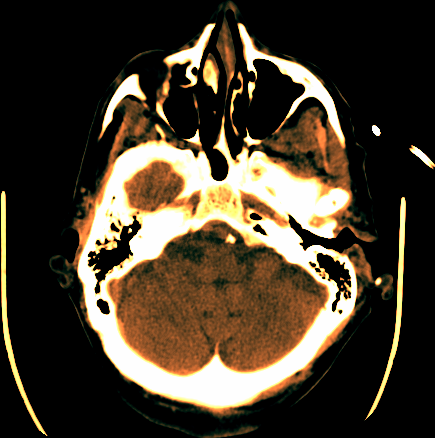

In [54]:
il[5678]